In [1]:
import os
import sys
import argparse
import shutil
import zipfile
import subprocess
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ.setdefault('OMP_NUM_THREADS', '1')
os.environ.setdefault('OPENBLAS_NUM_THREADS', '1')
os.environ.setdefault('MKL_NUM_THREADS', '1')
os.environ.setdefault('NUMEXPR_NUM_THREADS', '1')

'1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.decomposition import PCA

In [4]:
try:
    from sklearn.manifold import TSNE
    TSNE_AVAILABLE = True
except Exception:
    TSNE_AVAILABLE = False

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [5]:
BATCH_SIZE = 64
LATENT_DIM = 128
IMAGE_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 30
NUM_SAMPLES = 30000
NUM_WORKERS = 0
PIN_MEMORY = True if torch.cuda.is_available() else False
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_PREFIX = 'celeba_vae'
KAGGLE_DATASET = 'jessicali9530/celeba-dataset'

In [6]:
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path

def safe_run(cmd_list):
    try:
        proc = subprocess.run(cmd_list, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=False)
        return proc.returncode, proc.stdout, proc.stderr
    except Exception as e:
        return 1, '', str(e)

In [7]:
def ensure_kaggle_api():
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi  # noqa: F401
    except Exception:
        print("kaggle package not found — attempting to install via pip ...")
        rc, out, err = safe_run([sys.executable, '-m', 'pip', 'install', 'kaggle'])
        if rc != 0:
            print("pip install kaggle failed. Please install manually: pip install kaggle")
            return False
    kaggle_json = os.path.join(os.path.expanduser('~'), '.kaggle', 'kaggle.json')
    if not os.path.exists(kaggle_json):
        print("Kaggle credential file not found. Place kaggle.json at:", kaggle_json)
        return False
    try:
        os.chmod(kaggle_json, 0o600)
    except Exception:
        pass
    return True

In [8]:
def download_from_kaggle(target_dir):
    target_dir = ensure_dir(target_dir)
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
    except Exception as e:
        return False, f"kaggle import failed: {e}"
    api = KaggleApi()
    try:
        api.authenticate()
    except Exception as e:
        return False, f"kaggle authenticate failed: {e}"
    print("Starting Kaggle dataset download (may take a while)...")
    try:
        api.dataset_download_files(KAGGLE_DATASET, path=target_dir, unzip=False, quiet=False)
    except Exception as e:
        return False, f"Kaggle download failed: {e}"
    for fname in os.listdir(target_dir):
        if fname.lower().endswith('.zip'):
            zpath = os.path.join(target_dir, fname)
            print("Extracting", zpath)
            try:
                with zipfile.ZipFile(zpath, 'r') as zf:
                    zf.extractall(target_dir)
                try:
                    os.remove(zpath)
                except Exception:
                    pass
            except Exception as e:
                return False, f"zip extraction failed: {e}"
    return True, "kaggle download + extract succeeded"

In [9]:
class FlatFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, exts=('jpg','jpeg','png')):
        self.transform = transform
        self.paths = []
        root_dir = os.path.abspath(root_dir)
        for fname in sorted(os.listdir(root_dir)):
            if fname.lower().endswith(exts):
                self.paths.append(os.path.join(root_dir, fname))
        if len(self.paths) == 0:
            raise ValueError(f"No images found in {root_dir}")
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, 0

In [10]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, image_channels=3):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, image_channels, 4, 2, 1), nn.Sigmoid(),
        )
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(h.size(0), 256, 4, 4)
        return self.decoder(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar, kld_weight=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_weight * kld, recon_loss, kld

In [11]:
def run_pipeline(data_root, prefer_kaggle=True):
    print("Device:", DEVICE)
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
    ])
    using = None
    train_dataset = None
    test_dataset = None
    if prefer_kaggle and ensure_kaggle_api():
        kaggle_dir = ensure_dir(os.path.join(data_root, 'celeba_kaggle'))
        success, msg = download_from_kaggle(kaggle_dir)
        print("Kaggle download status:", success, msg)
        candidate_dirs = [kaggle_dir,
                          os.path.join(kaggle_dir, 'img_align_celeba'),
                          os.path.join(kaggle_dir, 'img_align_celeba', 'img_align_celeba')]
        found = None
        for c in candidate_dirs:
            if os.path.isdir(c) and len([f for f in os.listdir(c) if f.lower().endswith(('.jpg','.png'))])>0:
                found = c; break
        if found:
            print("Found images at:", found)
            try:
                train_dataset = FlatFolderDataset(found, transform=transform)
                test_dataset = FlatFolderDataset(found, transform=transform)
                using = 'kaggle_flat'
            except Exception as e:
                print("FlatFolderDataset failed:", e)

    # torchvision CelebA local
    if train_dataset is None:
        celeba_root = os.path.join(data_root, 'celeba')
        if os.path.isdir(celeba_root):
            try:
                from torchvision import datasets
                full_dataset = datasets.CelebA(root=celeba_root, split='train', download=False, transform=transform)
                test_ds = datasets.CelebA(root=celeba_root, split='test', download=False, transform=transform)
                num_samples = min(NUM_SAMPLES, len(full_dataset))
                train_dataset = Subset(full_dataset, range(num_samples))
                test_dataset = Subset(test_ds, range(min(5000, len(test_ds))))
                using = 'celeba_torchvision_local'
                print("Loaded torchvision CelebA from:", celeba_root)
            except Exception as e:
                print("torchvision.datasets.CelebA load failed:", e)

    # ImageFolder fallback (expects class subfolders)
    if train_dataset is None:
        local_folder = os.path.join(data_root, 'celeba_local')
        if os.path.isdir(local_folder):
            try:
                folder = ImageFolder(local_folder, transform=transform)
                num_samples = min(NUM_SAMPLES, len(folder))
                train_dataset = Subset(folder, range(num_samples))
                test_dataset = Subset(folder, range(min(1000, len(folder))))
                using = 'celeba_local_imagefolder'
                print("Using ImageFolder at:", local_folder)
            except Exception as e:
                print("ImageFolder load failed:", e)

    # Use data_root as flat folder
    if train_dataset is None:
        try:
            train_dataset = FlatFolderDataset(data_root, transform=transform)
            test_dataset = FlatFolderDataset(data_root, transform=transform)
            using = 'flat_data_root'
            print("Using flat folder dataset at:", data_root)
        except Exception:
            pass

    # Dummy fallback
    if train_dataset is None:
        class Dummy(torch.utils.data.Dataset):
            def __init__(self, n):
                self.n = n
            def __len__(self):
                return self.n
            def __getitem__(self, idx):
                return torch.rand(3, IMAGE_SIZE, IMAGE_SIZE), 0
        train_dataset = Dummy(NUM_SAMPLES)
        test_dataset = Dummy(1000)
        using = 'dummy'
        print("FALLBACK: Using dummy dataset (random). Reconstructions will be noise/gray.")

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    # Model
    model = ConvVAE(latent_dim=LATENT_DIM).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    train_losses, test_losses, recon_losses, kl_losses = [], [], [], []
    best_test_loss = float('inf')

    print("Starting training | dataset mode:", using)
    total_params = sum(p.numel() for p in model.parameters())
    print("Model params:", total_params)

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0; recon_epoch = 0.0; kl_epoch = 0.0
        for batch_idx, batch in enumerate(train_loader):
            data = batch[0] if isinstance(batch, (list, tuple)) else batch
            data = data.to(DEVICE)
            optimizer.zero_grad()
            kld_weight = min(1.0, epoch / 10.0)
            recon_batch, mu, logvar = model(data)
            loss, recon, kld = vae_loss(recon_batch, data, mu, logvar, kld_weight)
            loss.backward()
            optimizer.step()
            train_loss += loss.item(); recon_epoch += recon.item(); kl_epoch += kld.item()
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS} [{batch_idx}/{len(train_loader)}] loss/sample:{loss.item()/max(1, data.size(0)):.4f}")

        avg_train = train_loss / len(train_loader.dataset)
        avg_recon = recon_epoch / len(train_loader.dataset)
        avg_kl = kl_epoch / len(train_loader.dataset)
        train_losses.append(avg_train); recon_losses.append(avg_recon); kl_losses.append(avg_kl)

        # evaluation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                data = batch[0] if isinstance(batch, (list, tuple)) else batch
                data = data.to(DEVICE)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = vae_loss(recon_batch, data, mu, logvar, kld_weight=1.0)
                test_loss += loss.item()

        avg_test = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test)
        scheduler.step(avg_test)

        if avg_test < best_test_loss:
            best_test_loss = avg_test
            torch.save(model.state_dict(), f'{SAVE_PREFIX}_best.pth')

        print(f"Epoch {epoch+1}/{EPOCHS} | Train: {avg_train:.4f} | Test: {avg_test:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

    # load best
    best_path = f'{SAVE_PREFIX}_best.pth'
    if os.path.exists(best_path):
        model.load_state_dict(torch.load(best_path, map_location=DEVICE))

    # extract latents
    model.eval()
    latent_vectors = []
    sample_images = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= 50: break
            data = batch[0] if isinstance(batch, (list, tuple)) else batch
            data = data.to(DEVICE)
            mu, _ = model.encode(data)
            latent_vectors.append(mu.cpu().numpy())
            sample_images.append(data.cpu())

    if len(latent_vectors) == 0:
        print("No latent vectors extracted. Exiting.")
        return

    latent_vectors = np.vstack(latent_vectors)
    sample_images = torch.cat(sample_images)
    print("Latent shape:", latent_vectors.shape)

    # PCA + t-SNE guard
    print("Computing PCA...")
    pca_n = min(50, latent_vectors.shape[1], max(1, latent_vectors.shape[0]-1))
    pca = PCA(n_components=pca_n)
    latent_pca = pca.fit_transform(latent_vectors)
    print(f"PCA explained variance ({pca_n}): {pca.explained_variance_ratio_.sum():.2%}")

    latent_2d = None
    if TSNE_AVAILABLE and latent_pca.shape[0] >= 5:
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, max(5, latent_pca.shape[0]//3)), init='pca', n_jobs=1)
            latent_2d = tsne.fit_transform(latent_pca)
        except Exception as e:
            print("t-SNE failed; falling back to PCA 2D:", e)
            latent_2d = PCA(n_components=2).fit_transform(latent_pca)
    else:
        latent_2d = PCA(n_components=2).fit_transform(latent_pca)

    # reconstruction metrics
    n_test_samples = min(500, len(sample_images))
    test_samples = sample_images[:n_test_samples].to(DEVICE)
    with torch.no_grad():
        reconstructed, _, _ = model(test_samples)
    original_np = test_samples.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()

    ssim_scores, psnr_scores, mse_scores, mae_scores = [], [], [], []
    for i in range(n_test_samples):
        orig = np.transpose(original_np[i], (1,2,0))
        recon = np.transpose(reconstructed_np[i], (1,2,0))
        try:
            s = ssim(orig, recon, data_range=1.0, channel_axis=2)
        except Exception:
            s = 0.0
        p = psnr(orig, recon, data_range=1.0)
        m = np.mean((orig - recon)**2)
        a = np.mean(np.abs(orig - recon))
        ssim_scores.append(s); psnr_scores.append(p); mse_scores.append(m); mae_scores.append(a)
    ssim_scores = np.array(ssim_scores); psnr_scores = np.array(psnr_scores)
    mse_scores = np.array(mse_scores); mae_scores = np.array(mae_scores)

    # Visualizations
    print("Saving visualizations...")
    fig = plt.figure(figsize=(20,16))
    plt.subplot(4,3,1); plt.plot(train_losses,label='Train'); plt.plot(test_losses,label='Test'); plt.legend(); plt.title('Loss curves')
    plt.subplot(4,3,2); plt.plot(recon_losses,label='Recon'); plt.plot(kl_losses,label='KL'); plt.legend(); plt.title('Recon & KL')
    plt.subplot(4,3,3)
    if latent_2d is not None and latent_2d.shape[0] > 1:
        sc = plt.scatter(latent_2d[:,0], latent_2d[:,1], c=np.arange(latent_2d.shape[0]), s=8); plt.colorbar(sc)
    else:
        plt.text(0.5,0.5,"Insufficient 2D samples", ha='center')
    plt.title('Latent 2D')

    n_display = 6
    idxs = np.random.choice(n_test_samples, n_display, replace=(n_test_samples < n_display))
    for i, idx in enumerate(idxs):
        plt.subplot(4,6,7+i); plt.imshow(np.clip(np.transpose(original_np[idx], (1,2,0)),0,1)); plt.axis('off')
        plt.subplot(4,6,13+i); plt.imshow(np.clip(np.transpose(reconstructed_np[idx], (1,2,0)),0,1)); plt.axis('off')

    plt.subplot(4,3,7); plt.hist(ssim_scores, bins=50); plt.title(f'SSIM μ={np.mean(ssim_scores):.3f}')
    plt.subplot(4,3,8); plt.hist(psnr_scores, bins=50); plt.title(f'PSNR μ={np.mean(psnr_scores):.2f}')
    plt.subplot(4,3,9); plt.bar(range(LATENT_DIM), np.sort(np.std(latent_vectors,axis=0))[::-1]); plt.axhline(0.1, linestyle='--')
    plt.subplot(4,3,10); cumsum = np.cumsum(pca.explained_variance_ratio_); plt.plot(cumsum); plt.title('PCA cumvar')
    plt.subplot(4,3,11); plt.hist(mse_scores, bins=50); plt.subplot(4,3,12); plt.hist(mae_scores,bins=50)
    plt.tight_layout()
    analysis_file = f'{SAVE_PREFIX}_analysis.png'
    plt.savefig(analysis_file, dpi=200); print("Saved:", analysis_file)
    plt.show()

    # Generated faces
    with torch.no_grad():
        z = torch.randn(36, LATENT_DIM).to(DEVICE)
        gen = model.decode(z).cpu().numpy()
    fig2 = plt.figure(figsize=(8,8))
    for i in range(min(36, gen.shape[0])):
        plt.subplot(6,6,i+1); plt.imshow(np.clip(np.transpose(gen[i], (1,2,0)),0,1)); plt.axis('off')
    gen_file = f'{SAVE_PREFIX}_generated.png'; plt.savefig(gen_file, dpi=150); print("Saved:", gen_file); plt.show()

    # Interpolations
    fig3 = plt.figure(figsize=(16,8))
    n_interpolations = 3; n_steps = 8
    lv_count = latent_vectors.shape[0]
    for interp_idx in range(n_interpolations):
        i1 = np.random.randint(0, max(1, lv_count)); i2 = np.random.randint(0, max(1, lv_count))
        z1 = torch.tensor(latent_vectors[i1]).float().to(DEVICE); z2 = torch.tensor(latent_vectors[i2]).float().to(DEVICE)
        for step_idx, alpha in enumerate(np.linspace(0,1,n_steps)):
            z_interp = (1-alpha)*z1 + alpha*z2
            with torch.no_grad():
                dec = model.decode(z_interp.unsqueeze(0)).cpu().numpy()
            plt.subplot(n_interpolations, n_steps, interp_idx*n_steps + step_idx + 1)
            plt.imshow(np.clip(np.transpose(dec[0], (1,2,0)),0,1)); plt.axis('off')
    interp_file = f'{SAVE_PREFIX}_interpolations.png'; plt.savefig(interp_file, dpi=150); print("Saved:", interp_file); plt.show()

    # Latent traversals
    fig4 = plt.figure(figsize=(16,8))
    base_z = torch.randn(1, LATENT_DIM).to(DEVICE)
    n_dims_to_show = min(4, LATENT_DIM); n_steps_trav = 8
    for dim in range(n_dims_to_show):
        for step_idx, val in enumerate(np.linspace(-3,3,n_steps_trav)):
            zt = base_z.clone(); zt[0,dim] = val
            with torch.no_grad():
                dec = model.decode(zt).cpu().numpy()
            plt.subplot(n_dims_to_show, n_steps_trav, dim * n_steps_trav + step_idx + 1)
            plt.imshow(np.clip(np.transpose(dec[0], (1,2,0)),0,1)); plt.axis('off')
    trav_file = f'{SAVE_PREFIX}_traversal.png'; plt.savefig(trav_file, dpi=150); print("Saved:", trav_file); plt.show()

    # Summary
    print("\n==== SUMMARY ====")
    print("Dataset mode:", using)
    if using == 'dummy':
        print("WARNING: dummy dataset used -> reconstructions will be noise/gray.")
    print("Saved outputs:", analysis_file, gen_file, interp_file, trav_file, best_path)

Device: cuda
Starting Kaggle dataset download (may take a while)...
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Extracting ./data\celeba_kaggle\celeba-dataset.zip
Kaggle download status: True kaggle download + extract succeeded
Found images at: ./data\celeba_kaggle\img_align_celeba\img_align_celeba
Starting training | dataset mode: kaggle_flat
Model params: 2958659
Epoch 1/30 [0/3166] loss/sample:1331.5776
Epoch 1/30 [50/3166] loss/sample:631.8716
Epoch 1/30 [100/3166] loss/sample:373.8404
Epoch 1/30 [150/3166] loss/sample:320.1854
Epoch 1/30 [200/3166] loss/sample:246.2337
Epoch 1/30 [250/3166] loss/sample:219.8401
Epoch 1/30 [300/3166] loss/sample:183.1367
Epoch 1/30 [350/3166] loss/sample:183.2016
Epoch 1/30 [400/3166] loss/sample:158.1296
Epoch 1/30 [450/3166] loss/sample:158.9970
Epoch 1/30 [500/3166] loss/sample:149.3073
Epoch 1/30 [550/3166] loss/sa

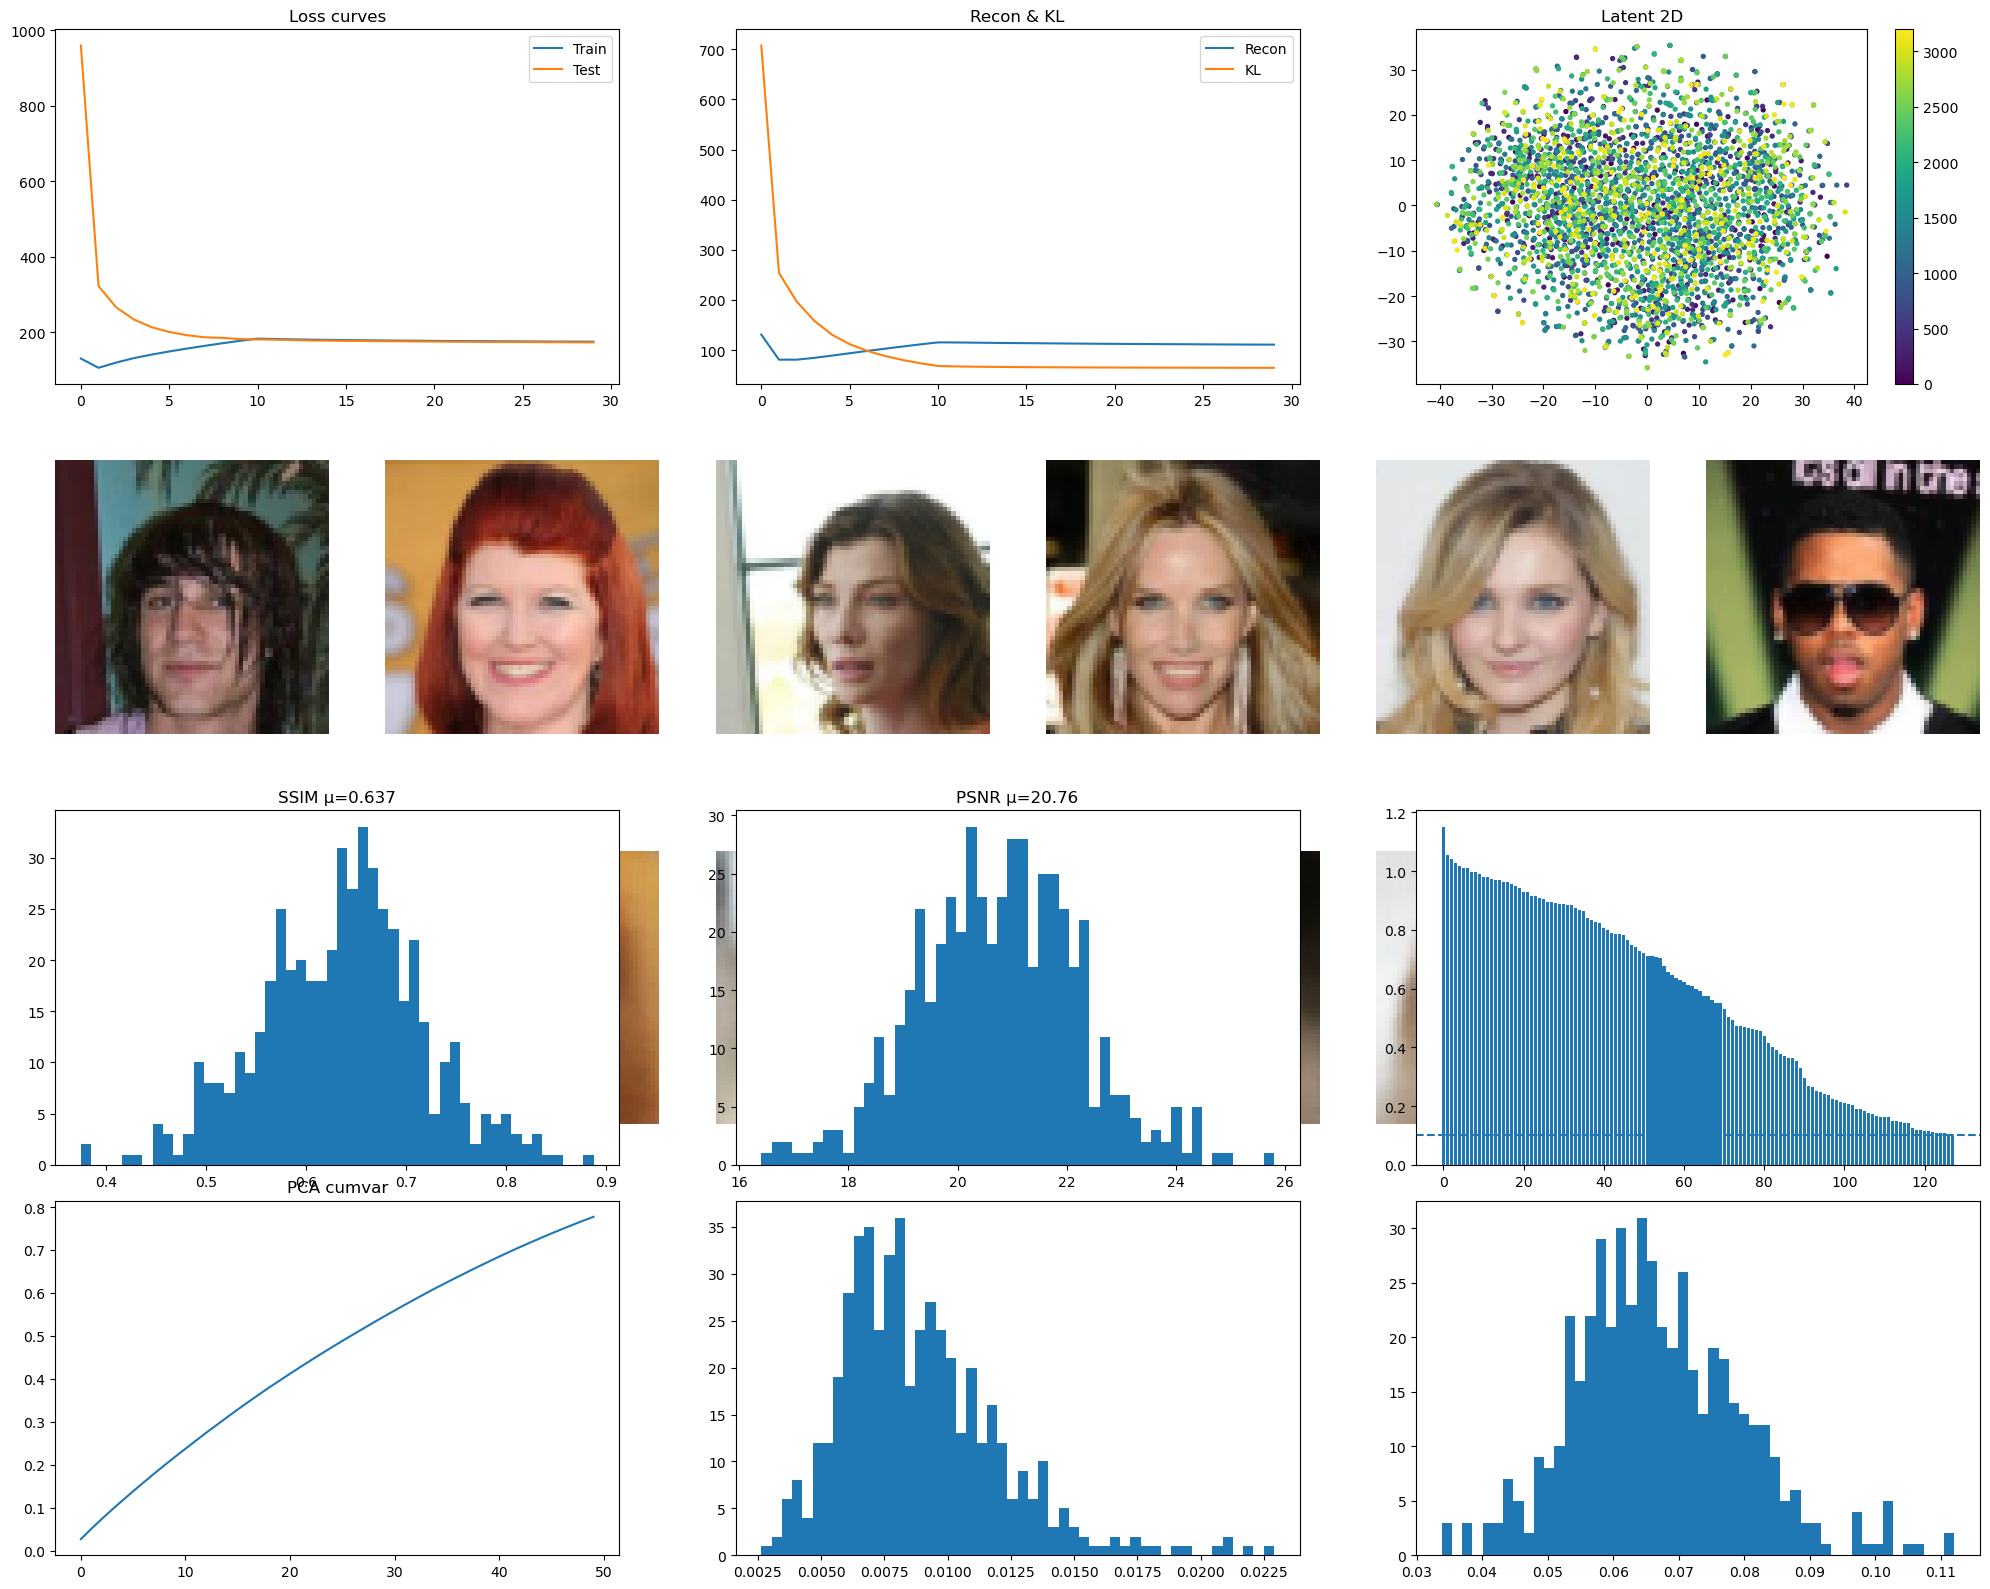

Saved: celeba_vae_generated.png


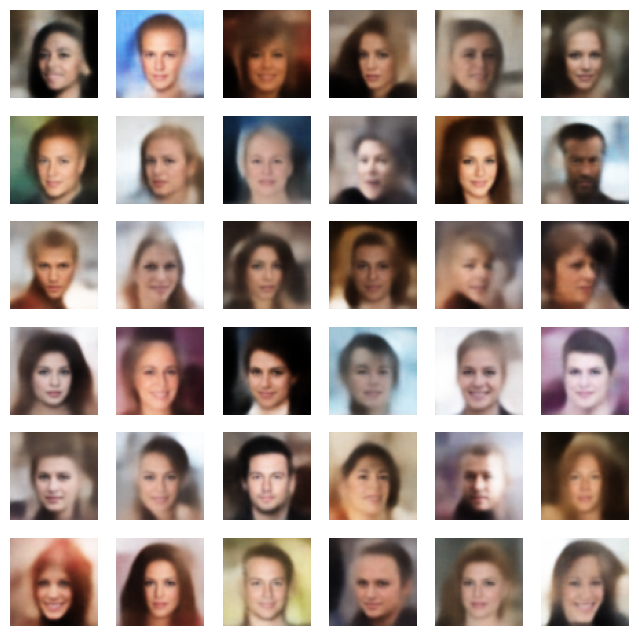

Saved: celeba_vae_interpolations.png


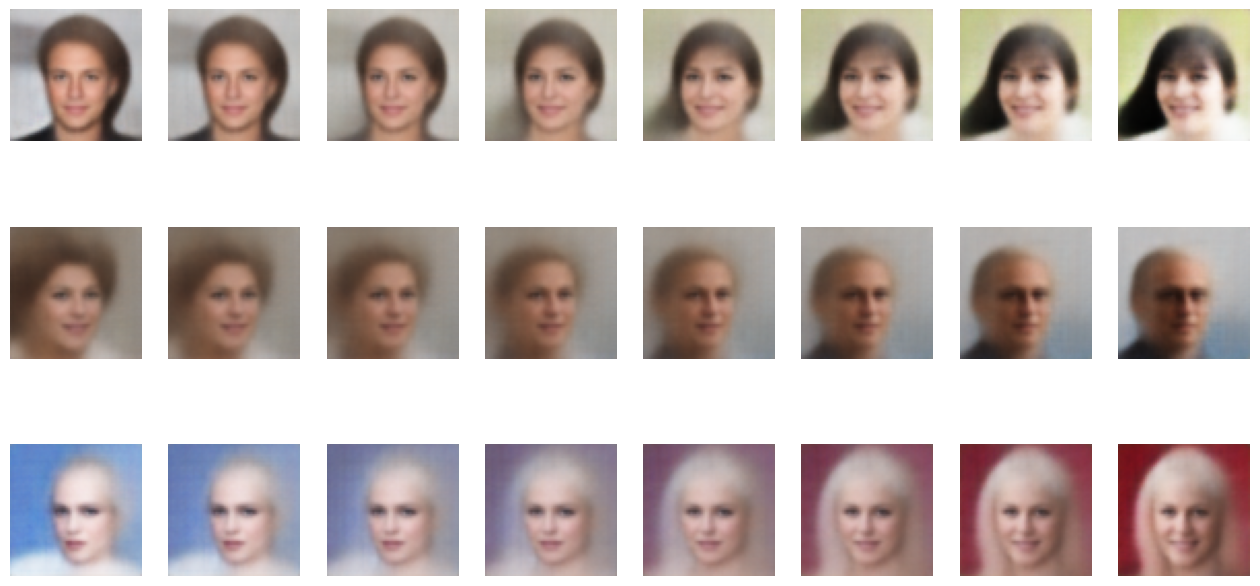

Saved: celeba_vae_traversal.png


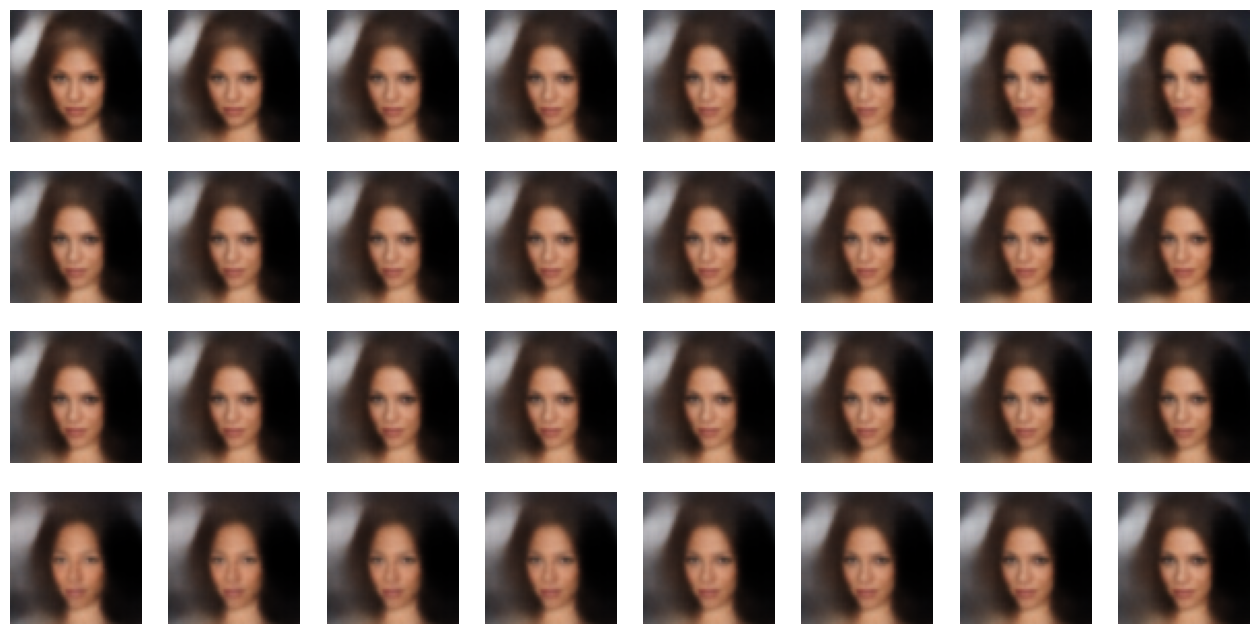


==== SUMMARY ====
Dataset mode: kaggle_flat
Saved outputs: celeba_vae_analysis.png celeba_vae_generated.png celeba_vae_interpolations.png celeba_vae_traversal.png celeba_vae_best.pth


In [12]:

if __name__ == '__main__':
    parser = argparse.ArgumentParser(add_help=True)
    parser.add_argument('--data-dir', type=str, default='./data', help='Base data directory (will create ./data/celeba_kaggle)')
    parser.add_argument('--no-kaggle', action='store_true', help='Do not attempt Kaggle download (use local data only)')

    # Use parse_known_args to avoid SystemExit in interactive environments
    args, unknown = parser.parse_known_args()
    try:
        run_pipeline(args.data_dir, prefer_kaggle=not args.no_kaggle)
    except Exception as e:
        print("An error occurred during pipeline execution:", e)
        raise
